In [3]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/Segmented_SAR_Segment  (1).zip'  # Update with your file path
extract_to = '/content/SAR_IMAGE_SEGMENT'

# Check if the zip file exists
if os.path.exists(zip_path):
  # Extract the ZIP file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
  print(f"File '{zip_path}' extracted to '{extract_to}' successfully.")
else:
  print(f"Error: File '{zip_path}' not found.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File '/content/drive/MyDrive/Segmented_SAR_Segment  (1).zip' extracted to '/content/SAR_IMAGE_SEGMENT' successfully.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% for validation
)

# Define paths and set up generators
dataset_path = '/content/SAR_IMAGE_SEGMENT'

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # VGG19 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 6401 images belonging to 4 classes.
Found 1599 images belonging to 4 classes.


In [5]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load VGG19 with pretrained weights, excluding the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers for your dataset
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate, epochs):
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        verbose=1
    )

    # Get the final validation accuracy
    val_acc = history.history['val_accuracy'][-1]
    return val_acc


In [7]:
# Hyperparameter grid
learning_rates = [1e-3, 1e-4]
epochs_list = [10, 20]
results = {}

# Loop through each hyperparameter combination
for lr in learning_rates:
    for epochs in epochs_list:
        print(f"Training with learning rate={lr} and epochs={epochs}")

        # Re-initialize the model for each combination
        temp_model = Model(inputs=base_model.input, outputs=output)

        # Train and evaluate the model
        val_acc = compile_and_train(temp_model, learning_rate=lr, epochs=epochs)

        # Store results
        results[(lr, epochs)] = val_acc
        print(f"Validation Accuracy with lr={lr}, epochs={epochs}: {val_acc}")


Training with learning rate=0.001 and epochs=10
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 131s 563ms/step - accuracy: 0.6430 - loss: 0.9822 - val_accuracy: 0.7874 - val_loss: 0.5384
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 102s 497ms/step - accuracy: 0.8426 - loss: 0.4033 - val_accuracy: 0.7323 - val_loss: 0.6524
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 102s 494ms/step - accuracy: 0.8601 - loss: 0.3553 - val_accuracy: 0.7799 - val_loss: 0.5488
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 141s 492ms/step - accuracy: 0.8929 - loss: 0.2937 - val_accuracy: 0.7592 - val_loss: 0.6482
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 144s 494ms/step - accuracy: 0.8923 - loss: 0.2796 - val_accuracy: 0.8005 - val_loss: 0.5160
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 142s 503ms/step - accuracy: 0.9015 - loss: 0.2762 - val_accuracy: 0.7642 - val_loss: 0.6306
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 123s 598ms/step - accuracy: 0.9095 - loss: 0.2300 - val_accuracy: 0.8061 - val_loss: 0.5565
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 121s 496ms/step - accuracy: 0.9127 - loss: 0.21

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step


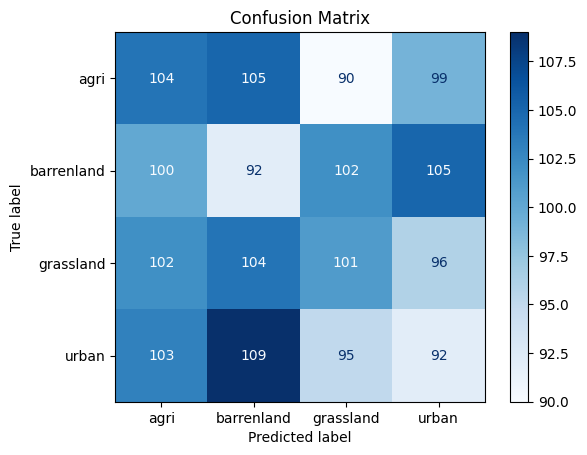

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have a test generator or test data
# Use the model to make predictions
y_true = validation_generator.classes  # True labels from the validation generator
y_pred_prob = temp_model.predict(validation_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


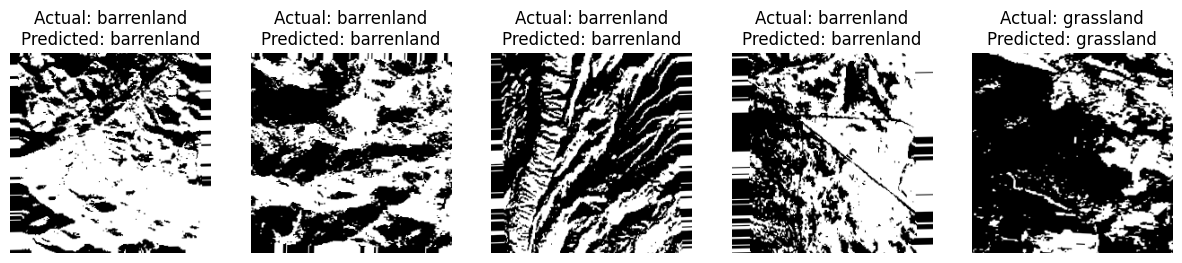

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random


# Get a batch of images and labels from the validation generator
images, labels = next(validation_generator)

# Choose 5 random images from the batch
num_images = 5
indices = random.sample(range(images.shape[0]), num_images)

# Plotting the images with actual and predicted labels
plt.figure(figsize=(15, 10))

for i, index in enumerate(indices):
    # Get the image and true label
    image = images[index]
    true_label = labels[index]

    # Expand the dimensions of the image and predict using the model
    image_expanded = np.expand_dims(image, axis=0)
    prediction_prob = temp_model.predict(image_expanded)
    predicted_label = np.argmax(prediction_prob)

    # Get the class label names
    class_names = list(validation_generator.class_indices.keys())
    true_label_name = class_names[np.argmax(true_label)]
    predicted_label_name = class_names[predicted_label]

    # Display the image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Actual: {true_label_name}\nPredicted: {predicted_label_name}")

plt.show()


In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,244,292 (88.67 MB)

 Trainable params: 3,219,908 (12.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Find the best parameters
best_params = max(results, key=results.get)
print(f"Best parameters: Learning Rate={best_params[0]}, Epochs={best_params[1]}")
print(f"Best Validation Accuracy: {results[best_params]:.4f}")
